In [1]:
%load_ext autoreload
%autoreload 2

In [71]:
from os.path import join, exists, isdir
from glob import glob

import torch
import numpy as np
from PIL import Image

from relfm.utils.visualize import show_grid_of_images, show_keypoint_matches
from relfm.utils.matching import mnn_matcher, add_kps_to_image, find_matches
from lib.r2d2.extract import extract_keypoints_modified


In [3]:
DATA_ROOT = "/home/lcur1325/datasets/hpatches-sequences-release/"

### Select a sample folder to test

In [11]:
category = "v_churchill"
category_folder = join(DATA_ROOT, category)

image_paths = sorted(glob(join(category_folder, "*.ppm")))
homography_paths = sorted(glob(join(category_folder, "H_*_*")))

In [14]:
img1_path = image_paths[0]
img2_path = image_paths[3]

H_path = homography_paths[3 - 1]

In [15]:
img1_path, img2_path, H_path

('/home/lcur1325/datasets/hpatches-sequences-release/v_churchill/1.ppm',
 '/home/lcur1325/datasets/hpatches-sequences-release/v_churchill/4.ppm',
 '/home/lcur1325/datasets/hpatches-sequences-release/v_churchill/H_1_4')

### Load a pair of images and homography

In [18]:
img1, img2 = Image.open(img1_path), Image.open(img2_path)
img1_np, img2_np = np.asarray(img1), np.asarray(img2)

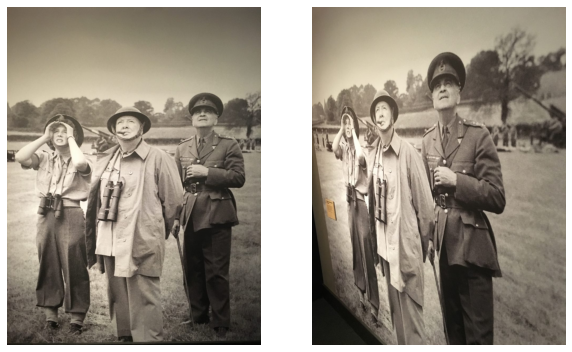

In [25]:
show_grid_of_images([img1_np, img2_np], n_cols=2, figsize=(10, 8))

In [26]:
H = np.loadtxt(H_path)

In [27]:
H

array([[ 3.1237e-01,  9.9342e-02,  8.5389e+00],
       [-2.9392e-01,  9.2363e-01,  1.4629e+01],
       [-7.4642e-04,  6.3257e-05,  9.9168e-01]])

### Extract keypoints and descriptors for both images

In [29]:
model_path = "../checkpoints/r2d2_WASF_N16.pt"
outputs = extract_keypoints_modified([img1, img2], model_path)

Launching on CPU

>> Creating net = Quad_L2Net_ConfCFS()
 ( Model size: 486K parameters )
extracting at scale x1.00 =  768x1024
extracting at scale x0.84 =  646x861
extracting at scale x0.71 =  543x724
extracting at scale x0.59 =  457x609
extracting at scale x0.50 =  384x512
extracting at scale x0.42 =  323x431
extracting at scale x0.35 =  272x362
extracting at scale x0.30 =  228x304
extracting at scale x0.25 =  192x256
extracting at scale x1.00 =  768x1024
extracting at scale x0.84 =  646x861
extracting at scale x0.71 =  543x724
extracting at scale x0.59 =  457x609
extracting at scale x0.50 =  384x512
extracting at scale x0.42 =  323x431
extracting at scale x0.35 =  272x362
extracting at scale x0.30 =  228x304
extracting at scale x0.25 =  192x256


### Apply homohraphy to keypoints detected in image 1

In [31]:
kps1 = outputs[0]["keypoints"]
des1 = outputs[0]["descriptors"]

kps2 = outputs[1]["keypoints"]
des2 = outputs[1]["descriptors"]

In [39]:
dist, matches = mnn_matcher(torch.from_numpy(des1), torch.from_numpy(des2))

In [41]:
matches.shape

(913, 2)

In [43]:
kps1.shape

(5000, 3)

In [46]:
def apply_homography_to_keypoints(kps1, homography):
    """Applies H to keypoints in image 1."""
    
    N = kps1.shape[0]
    if kps1.shape[1] == 3:
        pos_a = kps1[:, :2]
    elif kps1.shape[1] == 2:
        pos_a = kps1
    else:
        raise ValueError("Invalid shape for kps1.")
    
    # homogenize
    pos_a_h = np.concatenate([pos_a, np.ones([N, 1])], axis=1)
    
    # apply homography
    pos_b_proj_h = np.transpose(np.dot(homography, np.transpose(pos_a_h)))
    
    # back to 2D coordinates
    pos_b_proj = pos_b_proj_h[:, : 2] / pos_b_proj_h[:, 2 :]
    
    return pos_b_proj

In [52]:
kps2_gt = apply_homography_to_keypoints(kps1[:, :2], H)

In [53]:
kps1.shape, kps2.shape, kps2_gt.shape, matches.shape

((5000, 3), (5000, 3), (5000, 2), (913, 2))

#### Visualize detected and ground truth keypoints

In [76]:
img1_with_detected_kps1, kps1_cv2 = add_kps_to_image(img1_np, kps1)
img2_with_detected_kps2, kps2_cv2 = add_kps_to_image(img2_np, kps2)

img2_with_detected_kps2_and_gt_kps2, kps2_gt_cv2 = add_kps_to_image(img2_with_detected_kps2, kps2_gt, color=(0, 255, 0))

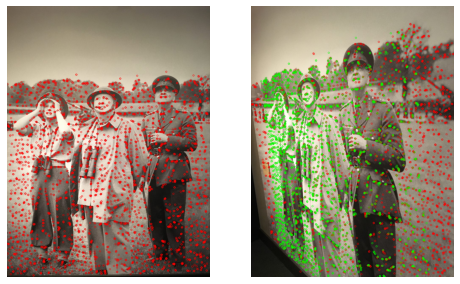

In [77]:
show_grid_of_images([img1_with_detected_kps1, img2_with_detected_kps2_and_gt_kps2], n_cols=2)

In [78]:
kps1.shape

(5000, 3)

In [79]:
matches_cv2 = find_matches(des1, des2)

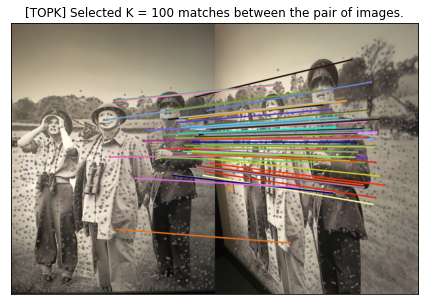

In [80]:
matches_img = show_keypoint_matches(
    img1_np, kps1_cv2, img2_np, kps2_cv2, matches_cv2, choose_matches="topk", K=100, 
)

In [81]:
kps1.shape, kps2.shape, kps2_gt.shape

((5000, 3), (5000, 3), (5000, 2))

In [86]:
kps1_selected = kps1[matches[:, 0]]
kps2_gt_selected = kps2_gt[matches[:, 0]]

In [87]:
kps1_selected.shape, kps2_gt_selected.shape

((913, 3), (913, 2))

In [ ]:
matches_by_homography = np.array()